In [1]:
import numpy as np, datetime, json, sys
import matplotlib.pyplot as plt
import tikzplotlib as tkz
from tqdm.auto import tqdm

from envs import IndependentPricingEnv
from agents import PricingAgentIndependent
from utils import generate_curves, generate_user_ranges

In [2]:
def trial_independent_products(num_products, num_actions, actions, horizon, user_ranges_overall, L_kernel, trial_id):

    np.random.seed(trial_id)
    
    demands = generate_curves(num_products, num_actions=num_actions)
    
    user_ranges = generate_user_ranges(num_products, user_ranges_overall[0], user_ranges_overall[1])

    actions_rep = np.repeat(actions.reshape(1, -1), num_products, axis=0)
    env = IndependentPricingEnv(num_products, num_actions, actions_rep, demands, user_ranges, seed=trial_id)
    optimal_actions, optimal_values = env.compute_optimal_actions()
    
    results_dict = {"res" : np.zeros((horizon, num_products)), "act" : np.zeros((horizon, num_products), dtype=int)}

    indep_instances = []
    for i in range(num_products): 
        indep_instances.append(PricingAgentIndependent(L_kernel, 1/(2*np.sqrt(user_ranges[i, 0])), horizon, actions))
    
    for t in tqdm(range(horizon)):
        
        for i in range(num_products):
            results_dict["act"][t, i] = indep_instances[i].pull()
        
        res = env.step(results_dict["act"][t, :])
        
        for i in range(num_products):
            indep_instances[i].update(res[i, 0] / res[i, 1])
            # results_dict["res"][t, i] = res[i, 1] * optimal_values[i] - res[i, 0] * actions[results_dict["act"][t, i]]
            results_dict["res"][t, i] = res[i, 1] * optimal_values[i] - res[i, 1] * actions[results_dict["act"][t, i]] * demands[i, results_dict["act"][t, i]]

    return results_dict

In [3]:
# Settings
num_actions = 10
num_products = 1
horizon = 300
user_ranges_overall = [10, 30]
actions = np.linspace(0.1, 1.0, num_actions)
L_kernel = 10
num_trials = 10

# Run
results_dict = []
for i in range(num_trials):
    results_dict.append(trial_independent_products(num_products, num_actions, actions, horizon, user_ranges_overall, L_kernel, i))

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

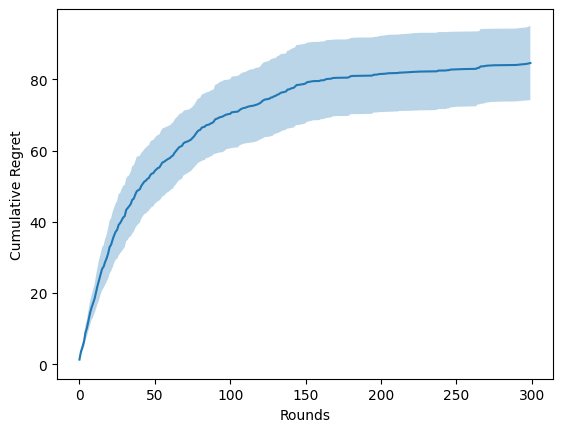

In [4]:
plt.figure()
x_plt = np.linspace(0, horizon-1, horizon, dtype=int)
aux = np.zeros((num_trials, horizon))
for i in range(num_trials):
    aux[i, :] = np.array(results_dict[i]["res"]).sum(axis=1)    
results = np.cumsum(aux, axis=1)
results_mean = np.mean(results, axis=0)
results_std = 1.96 * results.std(axis=0) / np.sqrt(num_trials)
plt.plot(x_plt, results_mean[x_plt])
plt.fill_between(x_plt, results_mean[x_plt] - results_std[x_plt], results_mean[x_plt] + results_std[x_plt], alpha=0.3)
plt.xlabel("Rounds")
plt.ylabel("Cumulative Regret")
time_print = datetime.datetime.now().strftime("(%Y-%b-%d %Ih%Mm%p)")
save_path = "results/indep_run" + time_print
tkz.save(save_path + ".tex")
plt.savefig(save_path + ".jpg")